In [0]:
!pip install -q transformers

In [0]:
!pip install catboost==0.7.2

In [0]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.1.0)


In [0]:
!wget  https://anaconda.org/pytorch/faiss-gpu/1.2.1/download/linux-64/faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!tar xvjf faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!cp -r lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
!pip install mkl

--2020-03-19 12:22:21--  https://anaconda.org/pytorch/faiss-gpu/1.2.1/download/linux-64/faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.92.24, 104.17.93.24, 2606:4700::6811:5c18, ...
Connecting to anaconda.org (anaconda.org)|104.17.92.24|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5a15c9cc393ec612061f033a/5ac54beae586bb11ec0ace46?response-content-disposition=attachment%3B%20filename%3D%22faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2%22%3B%20filename%2A%3DUTF-8%27%27faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2&response-content-type=application%2Fx-tar&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Expires=60&X-Amz-Date=20200319T122222Z&X-Amz-SignedHeaders=host&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEOv%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMSJIMEYCIQCdexjiwVGqxUb%2FL%2BcHCr%2FNpPGpnWBjY%2F%2FFe15UiZeHIQIhAP%2BVt2%2Fb%2BdkcVTyo37ii0lLixM28OlRihG5IhifNxBwfKr0DCNT%2F%2F%2

In [0]:
!pip install xgboost==0.81

In [0]:
!pip install -q pyLDAvis

In [0]:
import re
import nltk
import time
import random
import pickle
import sklearn
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import json
import faiss
import torch
import spacy
import pickle
from joblib import dump
import pyLDAvis
import pyLDAvis.gensim
import xgboost as xgb
from transformers import *
from flask import Flask
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from scipy.stats import uniform as sp_rand
from scipy.stats import randint as sp_randint
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.fasttext import FastText as FT_gensim

In [0]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
#!pip sklearn | grep ver

In [0]:
nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner", "textcat"])

nlp.max_length = 10000000

In [0]:
def save_obj(obj, name):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [0]:
df_tagged = pd.read_csv("data/tagged_processed.csv")

In [0]:
df_untagged = pd.read_csv("data/untagged_processed.csv")

In [0]:
distribution_tags = {}
for i, row in df_tagged.iterrows():
  tags = str(row["Tags"])
  x = tags.split(">")
  for t in x:
    if t.strip() != "":
      tag = t[1:]
      if tag in distribution_tags:
        distribution_tags[tag] += 1
      else:
        distribution_tags[tag] = 1

In [0]:
distri_tags_sort = {k: v for k, v in sorted(distribution_tags.items(), key=lambda item: item[1], reverse=True)}

In [0]:
nb_occ = 200
labels = []
for k, v in distri_tags_sort.items():
  if v >= nb_occ:
    labels.append(k)
  else:
    break

In [0]:
pairs = []
ys = []
corpus_body = []
corpus_title = []
for i, row in df_tagged.iterrows():
    obs = str(row["Body"]) + " " + str(row["Title"])
    obs_body = str(row["Body"])
    obs_title = str(row["Title"])
    tags = str(row["Tags"])
    x = tags.split(">")
    ls = []
    j = 0
    for t in x:
        if t.strip() != "":
            label = t[1:]
            if label in labels:
                pairs.append((obs, label))
                corpus_body.append(obs_body)
                corpus_title.append(obs_title)
                ls.append(label)
                j += 1
    for k in range(0, j):
        ys.append(ls)

In [0]:
corpus = []
y = []
for (obs, tag) in pairs:
    '''
    for tag in tags:
        obs = obs + " " + tag
    '''
    corpus.append(obs)
    y.append(tag)

In [0]:
vectorizer = CountVectorizer()

In [0]:
vectorizerIdf = TfidfVectorizer()

In [0]:
X_BOW = vectorizer.fit_transform(corpus)

In [0]:
X_BOW

<22476x16863 sparse matrix of type '<class 'numpy.int64'>'
	with 742823 stored elements in Compressed Sparse Row format>

In [0]:
X_idf = vectorizerIdf.fit_transform(corpus)

**Word Embedding : DistilBert, Glove and FastText**

```
DistilBert Embedding
```

In [0]:
MODELS = [
            (DistilBertModel, DistilBertTokenizer, 'distilbert-base-uncased'),
         ]

In [0]:
for model_class, tokenizer_class, pretrained_weights in MODELS:
    # Load pretrained model/tokenizer
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)

In [0]:
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

In [0]:
tokenized = []
last_hidden_states = []
for x in corpus:
    tokenized = tokenizer.encode(x[:1500], add_special_tokens=True)
    input_ids = torch.Tensor(tokenized).to(torch.int64).unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_ids)
    
    last_hidden_states.append(outputs[0])

In [0]:
X_DistBert_CLS = []
for i in range(0, len(last_hidden_states)):
    X_DistBert_CLS.append(list(last_hidden_states[i][:,0,:].numpy()[0]))

In [0]:
X_DistBert_CLS = np.array(X_DistBert_CLS)

In [0]:
X_DistBert_CLS

array([[-0.32200024, -0.2247258 , -0.1527576 , ..., -0.07875298,
         0.0547769 ,  0.23462823],
       [-0.3247492 , -0.15595482,  0.06549278, ..., -0.34466192,
         0.10262289,  0.1779712 ],
       [-0.44914186, -0.04718838, -0.23378843, ..., -0.37297726,
        -0.10779209,  0.26637387],
       ...,
       [-0.40703103, -0.01475961, -0.26701707, ..., -0.3710595 ,
         0.06033126,  0.3010649 ],
       [-0.51474047, -0.06381474, -0.13629295, ..., -0.12964098,
         0.17787687,  0.21211788],
       [-0.37633276, -0.21602085,  0.11032974, ..., -0.20941058,
         0.0129345 ,  0.10568312]], dtype=float32)

```
Word2Vec training Embedding
```

In [0]:
documents = []
for sent in corpus:
    document = nlp(sent)
    documents.append([token.text for token in document])

In [0]:
model = Word2Vec(documents, size=50, min_count=1, workers=4)

In [0]:
vector = model.wv['computer']
vector

array([-1.9083178 ,  0.5116892 , -0.314951  , -0.15765908,  0.86094147,
        0.15221643,  1.3443738 ,  0.27585837,  2.084731  , -1.4390497 ,
       -0.46788627, -0.38640028, -1.1757256 ,  0.09781265, -0.2461647 ,
        0.5964242 , -0.21917285, -0.29594803, -1.171752  ,  0.12788025,
        1.2323127 , -0.2270452 , -0.02115183,  1.139303  , -0.34416997,
        1.2396618 ,  0.64105713, -0.3580622 , -1.0907371 ,  0.28498432,
        0.9891807 ,  0.20988388,  0.74915993, -0.85198456, -0.10912831,
        0.21461192, -0.6936659 , -0.8107961 ,  0.8231564 ,  0.64520776,
        2.023557  , -1.023134  ,  1.1870298 , -0.89235246,  1.037366  ,
        1.1259738 , -1.6199178 , -0.04978434,  0.8692719 , -0.7397495 ],
      dtype=float32)

In [0]:
X_word2vec = []
for sents in documents:
    vec = np.array([0]*50)
    nb = 0
    for token in sents:
        vec = vec + model.wv[token]
        nb += 1
    X_word2vec.append(vec/nb)

In [0]:
X_word2vec = np.array(X_word2vec)

In [0]:
X_word2vec

array([[-0.79571883, -0.2186781 ,  0.41890451, ...,  0.92915566,
        -0.03633774, -0.42629318],
       [-0.52227446, -0.04067185,  1.09985832, ...,  0.29243907,
        -0.32213691, -0.44100115],
       [-0.39381788,  0.69390148,  1.03112647, ...,  1.12362145,
        -0.21546032, -0.32130575],
       ...,
       [-0.2186136 , -0.80908641,  1.09814315, ...,  0.27765734,
        -0.72874445,  0.19682066],
       [ 0.47504942,  0.04767128,  0.86062513, ...,  1.38533943,
         0.20193655, -0.06977134],
       [-0.70289072,  0.28445417,  0.89204875, ...,  0.90064288,
        -0.14234533, -0.13177183]])

```
Glove pre-trained Embedding
```

In [0]:
embed_dict = {}
with open("data/glove.6B.50d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embed_dict[word] = vector

In [0]:
vocab = set()
for sents in corpus:
  docu = nlp(sents)
  for token in docu:
    vocab.add(token.text)

embeddings_dict = {}
for k, v in embed_dict.items():
  if k in vocab:
    embeddings_dict[k] = v

In [0]:
len(embeddings_dict)

8401

In [0]:
X_Glove = []
for sents in documents:
    vec = np.array([0]*50)
    for token in sents:
        nb = 0
        if token in list(embeddings_dict.keys()):
            vec = vec + embeddings_dict[token]
            nb += 1
    if nb != 0:
        vec = vec / nb
    X_Glove.append(vec)

In [0]:
X_Glove = np.array(X_Glove)

In [0]:
X_Glove

array([[ 4.13629214, 10.07610111,  2.14078767, ...,  6.37537002,
         6.44668773, 13.95529591],
       [20.38532823,  0.44114125,  6.15501768, ..., 15.75760607,
         9.20760424,  9.35656211],
       [ 5.89050378,  1.33663661,  5.51109607, ..., 18.16300069,
         3.99589292,  4.12070216],
       ...,
       [-4.40954792,  5.74167393,  1.61801995, ...,  9.52198712,
         6.01225798, 11.69491716],
       [21.13150459,  6.60016093, 16.40189522, ..., 24.87864701,
         7.08926095, 10.41096825],
       [ 7.92499815, -5.40016977,  3.04827394, ..., 10.95748143,
         4.04600898, 17.05304092]])

```
FastText Embedding
```

In [0]:
text = ' '.join(corpus)

In [0]:
corpus_file = r"dump.txt"
File_object = open(corpus_file, "w+", encoding='utf-8')
File_object.write(text)
File_object.close()

In [0]:
model = FT_gensim(size=50)

/usr/local/lib/python3.6/dist-packages/gensim/models/fasttext.py:383: DeprecationWarning: Call to deprecated `bucket` (Attribute will be removed in 4.0.0, use trainables.bucket instead).
  self.wv.bucket = self.bucket


In [0]:
# build the vocabulary
model.build_vocab(corpus_file=corpus_file)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/models/fasttext.py:522: DeprecationWarning: Call to deprecated `layer1_size` (Attribute will be removed in 4.0.0, use self.trainables.layer1_size instead).
  l1_size = self.layer1_size * np.dtype(np.float32).itemsize
/usr/local/lib/python3.6/dist-packages/gensim/models/fasttext.py:526: DeprecationWarning: Call to deprecated `bucket` (Attribute will be removed in 4.0.0, use trainables.bucket instead).
  num_buckets = self.bucket


In [0]:
# train the model
model.train(
    corpus_file=corpus_file, epochs=model.epochs,
    total_examples=model.corpus_count, total_words=model.corpus_total_words
)

In [0]:
print(model)

FastText(vocab=12386, size=50, alpha=0.025)


In [0]:
model.wv["computer"]

array([-1.0728981 , -0.5186528 , -0.9723546 , -1.326872  ,  0.23038949,
        0.5749706 ,  0.13601047, -1.2403526 , -0.09189867,  0.91840315,
        0.60336715, -3.1103435 , -0.18157142, -1.2083105 ,  1.0151727 ,
       -0.18720818,  0.22286929, -1.3547765 ,  0.267672  , -0.18894011,
        1.7396865 , -0.57955796, -0.11591771,  0.1963597 , -0.07045548,
        0.40076986, -0.5568745 , -0.47768453,  0.11482572,  0.09931155,
       -0.7605106 ,  0.93142706,  1.0734566 ,  0.2293205 ,  0.35433537,
        1.8377832 , -0.63868254, -0.4505856 , -1.4305067 ,  0.84406394,
       -0.36692917,  0.48186564, -0.09121522, -1.3166347 , -2.4130466 ,
        0.02578922, -0.21412133,  0.7740424 , -0.6806839 ,  1.8350227 ],
      dtype=float32)

In [0]:
X_fastText = []
for sents in documents:
    vec = np.array([0]*50)
    nb = 0
    for token in sents:
        if token in model.wv.vocab:
            vec = vec + model.wv[token]
            nb += 1
    X_fastText.append(vec/nb)

In [0]:
X_fastText = np.array(X_fastText)

In [0]:
X_fastText

array([[-0.69189064, -0.33077427, -0.62747612, ...,  0.49841403,
        -0.43600051,  1.17844311],
       [-0.63644818, -0.30632123, -0.57667407, ...,  0.45939569,
        -0.40209896,  1.0825682 ],
       [-0.70714875, -0.34033791, -0.64227698, ...,  0.51153119,
        -0.44607811,  1.20585062],
       ...,
       [-0.55701343, -0.26606456, -0.50604665, ...,  0.40365262,
        -0.35265081,  0.95131806],
       [-0.68690455, -0.32989183, -0.6229732 , ...,  0.49555358,
        -0.43271586,  1.16837512],
       [-0.65686211, -0.31565464, -0.59753819, ...,  0.47374759,
        -0.41478042,  1.11933531]])

**Tags predictions**

In [0]:
n_labels = 3

In [0]:
def accuracy(Y_pred, y_true):
    # Weight of the three first label
    coef1 = 1
    coef2 = 0.5
    coef3 =  0.25

    # accuracy score
    count = 0
    for i in range(0, len(Y_pred)):
        tag1 = Y_pred[i][0]
        tag2 = Y_pred[i][1]
        tag3 = Y_pred[i][2]
        tag_true = y_true[i]
        if tag_true == tag1:
            count += coef1
        if tag_true == tag2:
            count += coef2
        if tag_true == tag3:
            count += coef3
    return count/len(Y_pred)

In [0]:
def accuracy_faiss(I, y_train, y_test):
    # Get the three first labels
    Y_pred = []
    for i in I:
        labels = []
        for j in range(0, n_labels):
            labels.append(y_train[i[j]])
        Y_pred.append(labels)

    return accuracy(Y_pred, y_test)
    

In [0]:
def own_metric(clf, X, y_true):

    y_preds = clf.predict_proba(X)

    # get the three first labels for input
    Y_pred = []
    for y_pred in y_preds:
        tmp = y_pred.argsort()[-n_labels:][::-1]
        labels = []
        for i in tmp:
            labels.append(clf.classes_[i])
        Y_pred.append(labels)

    return accuracy(Y_pred, y_true)

In [0]:
class TemplateClassifier(BaseEstimator, ClassifierMixin):

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def get_params(self, deep=True):
        out = dict()
        for key in self._get_param_names():
            out[key] = value
        return out

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self.model, parameter, value)
        return self

    def score(self, X, y):
        return own_metric(self.model, X, y)

In [0]:
class MNB_clf(TemplateClassifier):
    def __init__(self):
        self.model = MultinomialNB()

In [0]:
class dummy_clf(TemplateClassifier):
    def __init__(self):
        self.model = DummyClassifier(strategy="most_frequent")

In [0]:
class xgb_clf(TemplateClassifier):
    def __init__(self):
        self.model = xgb.XGBClassifier(learning_rate=0.1, objective='reg:logistic')

In [0]:
class lgbm_clf(TemplateClassifier):
    def __init__(self):
        self.model = LGBMClassifier(learning_rate=0.05)

In [0]:
class catBoost_clf(TemplateClassifier):
    def __init__(self):
        self.model = CatBoostClassifier()

In [0]:
# Dummy classifier
dummy = dummy_clf()

# XGBoost
params_xgb = {'gamma': sp_rand(0, 10),
              'max_depth': sp_randint(3, 10),
              'min_child_weight': sp_randint(1, 6)
              #'learning_rate': sp_rand(0.01, 0.1),
              }
xgb_model = xgb_clf()
grid_xgb = RandomizedSearchCV(xgb_model, params_xgb, cv=5, n_iter=10, n_jobs=-1)

# Catboost
params_catBoost = {'num_trees': [100, 200, 300, 500],
                   'learning_rate': [ 0.03, 0.5, 1],
                   'depth':np.arange(4,11)
                  }
catBoost_model = catBoost_clf()
grid_catBoost = RandomizedSearchCV(catBoost_model, params_catBoost, cv=5, n_jobs=-1)

# LightGBM
params_lgbm = {'num_leaves':sp_randint(3, 10),
               'max_depth': sp_randint(3, 10)
               #'min_data_in_leaf': sp_randint(100, 800),
               }
lgbm_model = lgbm_clf()
grid_lgbm = RandomizedSearchCV(lgbm_model, params_lgbm, n_iter=10, cv=5, n_jobs=-1)

# Naive_bayes MultinomialNB
params_lMNB = {'alpha': sp_rand()}
MultinomialNB_model = MNB_clf()
grid_MNB = RandomizedSearchCV(MultinomialNB_model, params_lMNB, n_iter=10, cv=5, n_jobs=-1)

**Tf**

In [0]:
X_BOW = X_BOW.astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X_BOW,
                                                    y, test_size = 0.2, random_state = 0)

In [0]:
score_tf = {}

In [0]:
# FAISS
# Non-parametric model
index = faiss.IndexFlatL2(X_train.shape[1])
index.add(X_train.todense())

k = n_labels
D, I = index.search(X_test.todense(), k)

score_tf['faiss'] = {"accuracy": accuracy_faiss(I, y_train, y_test)}

In [0]:
for clf in [dummy, xgb_model, lgbm_model, MultinomialNB_model]:

    start_time = time.time()
    clf.fit(X_train, y_train)
    time_svm = time.time() - start_time
    
    score_tf[clf.__class__.__name__] = {'training time': time_svm}

    start_time = time.time()
    score_tf[clf.__class__.__name__]['accuracy'] = clf.score(X_test, y_test)
    time_svm = time.time() - start_time

    score_tf[clf.__class__.__name__]['test time'] = time_svm

In [0]:
score_tf

{'MNB_clf': {'accuracy': 0.6391792704626335,
  'test time': 0.04204702377319336,
  'training time': 0.10145807266235352},
 'dummy_clf': {'accuracy': 0.13228425266903915,
  'test time': 0.02371954917907715,
  'training time': 0.012522220611572266},
 'faiss': {'accuracy': 0.4698620996441281},
 'lgbm_clf': {'accuracy': 0.6729314946619217,
  'test time': 1.543994665145874,
  'training time': 155.89938187599182},
 'xgb_clf': {'accuracy': 0.6851089857651246,
  'test time': 2.0271799564361572,
  'training time': 158.25072598457336}}

**Tf-idf**

In [0]:
X_idf = X_idf.astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X_idf,
                                                    y, test_size = 0.2, random_state = 0)

In [0]:
score_idf = {}

In [0]:
# FAISS
# Non-parametric model
index = faiss.IndexFlatL2(X_train.shape[1])
index.add(X_train.todense())

k = n_labels
D, I = index.search(X_test.todense(), k)

score_idf['faiss'] = {"accuracy": accuracy_faiss(I, y_train, y_test)}

In [0]:
for clf in [dummy, xgb_model, lgbm_model, MultinomialNB_model]:

    start_time = time.time()
    clf.fit(X_train, y_train)
    time_svm = time.time() - start_time

    score_idf[clf.__class__.__name__] = {'training time': time_svm}

    start_time = time.time()
    score_idf[clf.__class__.__name__]['accuracy'] = clf.score(X_test, y_test)
    time_svm = time.time() - start_time

    score_idf[clf.__class__.__name__]['test time'] = time_svm

In [0]:
score_idf

{'MNB_clf': {'accuracy': 0.4677491103202847,
  'test time': 0.04044485092163086,
  'training time': 0.09149503707885742},
 'dummy_clf': {'accuracy': 0.13228425266903915,
  'test time': 0.022820711135864258,
  'training time': 0.010898351669311523},
 'faiss': {'accuracy': 0.5433718861209964},
 'lgbm_clf': {'accuracy': 0.6568616548042705,
  'test time': 1.6430444717407227,
  'training time': 432.4166615009308},
 'xgb_clf': {'accuracy': 0.6765458185053381,
  'test time': 1.8413898944854736,
  'training time': 274.5806174278259}}

**DistilBert**

In [0]:
X_DistBert_CLS = X_DistBert_CLS.astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X_DistBert_CLS,
                                                    y, test_size = 0.2, random_state = 0)

In [0]:
score_distil = {}

In [0]:
# FAISS
# Non-parametric model
index = faiss.IndexFlatL2(X_train.shape[1])
index.add(X_train)

k = n_labels
D, I = index.search(X_test, k)

score_distil['faiss'] = {"accuracy": accuracy_faiss(I, y_train, y_test)}

In [0]:
for clf in [dummy, xgb_model, lgbm_model]:

    start_time = time.time()
    clf.fit(X_train, y_train)
    time_svm = time.time() - start_time

    score_distil[clf.__class__.__name__] = {'training time': time_svm}

    start_time = time.time()
    score_distil[clf.__class__.__name__]['accuracy'] = clf.score(X_test, y_test)
    time_svm = time.time() - start_time

    score_distil[clf.__class__.__name__]['test time'] = time_svm

In [0]:
score_distil

{'dummy_clf': {'accuracy': 0.13228425266903915,
  'test time': 0.022249460220336914,
  'training time': 0.011551380157470703},
 'faiss': {'accuracy': 0.37488879003558717},
 'lgbm_clf': {'accuracy': 0.41642571174377224,
  'test time': 1.7156946659088135,
  'training time': 1168.9635548591614},
 'xgb_clf': {'accuracy': 0.46891681494661924,
  'test time': 2.4315671920776367,
  'training time': 3158.334127187729}}

**Glove pre-training**

In [0]:
X_Glove = X_Glove.astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X_Glove,
                                                    y, test_size = 0.2, random_state = 0)

In [0]:
score_gpre = {}

In [0]:
# FAISS
# Non-parametric model
index = faiss.IndexFlatL2(X_train.shape[1])
index.add(X_train)

k = n_labels
D, I = index.search(X_test, k)

score_gpre['faiss'] = {"accuracy": accuracy_faiss(I, y_train, y_test)}

In [0]:
for clf in [dummy, xgb_model, lgbm_model]:

    start_time = time.time()
    clf.fit(X_train, y_train)
    time_svm = time.time() - start_time

    score_gpre[clf.__class__.__name__] = {'training time': time_svm}

    start_time = time.time()
    score_gpre[clf.__class__.__name__]['accuracy'] = clf.score(X_test, y_test)
    time_svm = time.time() - start_time

    score_gpre[clf.__class__.__name__]['test time'] = time_svm

In [0]:
score_gpre

{'dummy_clf': {'accuracy': 0.13228425266903915,
  'test time': 0.019584178924560547,
  'training time': 0.014306306838989258},
 'faiss': {'accuracy': 0.3027135231316726},
 'lgbm_clf': {'accuracy': 0.3613767793594306,
  'test time': 1.625718355178833,
  'training time': 67.57413458824158},
 'xgb_clf': {'accuracy': 0.39707517793594305,
  'test time': 1.987914800643921,
  'training time': 216.92689418792725}}

**Glove training**

In [0]:
X_word2vec = X_word2vec.astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X_word2vec,
                                                    y, test_size = 0.2, random_state = 0)

In [0]:
score_gtra = {}

In [0]:
# FAISS
# Non-parametric model
index = faiss.IndexFlatL2(X_train.shape[1])
index.add(X_train)

k = n_labels
D, I = index.search(X_test, k)

score_gtra['faiss'] = {"accuracy": accuracy_faiss(I, y_train, y_test)}

In [0]:
for clf in [dummy, xgb_model, lgbm_model]:

    start_time = time.time()
    clf.fit(X_train, y_train)
    time_svm = time.time() - start_time

    score_gtra[clf.__class__.__name__] = {'training time': time_svm}

    start_time = time.time()
    score_gtra[clf.__class__.__name__]['accuracy'] = clf.score(X_test, y_test)
    time_svm = time.time() - start_time
    
    score_gtra[clf.__class__.__name__]['test time'] = time_svm

In [0]:
score_gtra

{'dummy_clf': {'accuracy': 0.13228425266903915,
  'test time': 0.02431797981262207,
  'training time': 0.016663551330566406},
 'faiss': {'accuracy': 0.5840747330960854},
 'lgbm_clf': {'accuracy': 0.55043371886121,
  'test time': 1.490851879119873,
  'training time': 67.17658400535583},
 'xgb_clf': {'accuracy': 0.6007006227758007,
  'test time': 1.9708335399627686,
  'training time': 219.28987526893616}}


**FastText**


In [0]:
X_fastText = X_fastText.astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X_fastText,
                                                    y, test_size = 0.2, random_state = 0)

In [0]:
score_fast = {}

In [0]:
# FAISS
# Non-parametric model
index = faiss.IndexFlatL2(X_train.shape[1])
index.add(X_train)

k = n_labels
D, I = index.search(X_test, k)

score_fast['faiss'] = {"accuracy": accuracy_faiss(I, y_train, y_test)}

In [0]:
for clf in [dummy, xgb_model, lgbm_model]:

    start_time = time.time()
    clf.fit(X_train, y_train)
    time_svm = time.time() - start_time

    score_fast[clf.__class__.__name__] = {'training time': time_svm}

    start_time = time.time()
    score_fast[clf.__class__.__name__]['accuracy'] = clf.score(X_test, y_test)
    time_svm = time.time() - start_time
    
    score_fast[clf.__class__.__name__]['test time'] = time_svm

In [0]:
score_fast

{'dummy_clf': {'accuracy': 0.13228425266903915,
  'test time': 0.020730257034301758,
  'training time': 0.014518499374389648},
 'faiss': {'accuracy': 0.19567393238434164},
 'lgbm_clf': {'accuracy': 0.2530026690391459,
  'test time': 2.2070353031158447,
  'training time': 42.925930976867676},
 'xgb_clf': {'accuracy': 0.25250222419928825,
  'test time': 1.9649121761322021,
  'training time': 196.9175672531128}}

**Comparaison of the differents feature models**

In [0]:
score_distil['MNB_clf'] = {'accuracy': 0, 'training time': 0}
score_gpre['MNB_clf'] = {'accuracy': 0, 'training time': 0}
score_gtra['MNB_clf'] = {'accuracy': 0, 'training time': 0}
score_fast['MNB_clf'] = {'accuracy': 0, 'training time': 0}

In [0]:
indices = np.arange(6)
feature_model = ['Tf', 'Tf-Ifd', 'Distil Bert', 'Glove Pre-training', 'Glove training', 'fastText']

In [0]:
indices1 = np.arange(2)
feature_model1 = ['Tf', 'Tf-Ifd']
indices2 = np.arange(4)
feature_model2 = ['Distil Bert', 'Glove Pre-training', 'Glove training', 'fastText']

In [0]:
score = []
training_time = []
for cls_name in ['dummy_clf', 'xgb_clf', 'lgbm_clf', 'MNB_clf', 'faiss']:
    sco = []
    tr = []

    sco.append(score_tf[cls_name]['accuracy'])
    sco.append(score_idf[cls_name]['accuracy'])
    sco.append(score_distil[cls_name]['accuracy'])
    sco.append(score_gpre[cls_name]['accuracy'])
    sco.append(score_gtra[cls_name]['accuracy'])
    sco.append(score_fast[cls_name]['accuracy'])
    if cls_name != 'faiss':
        tr.append(score_tf[cls_name]['training time'])
        tr.append(score_idf[cls_name]['training time'])
        tr.append(score_gpre[cls_name]['training time'])
        tr.append(score_gtra[cls_name]['training time'])
        tr.append(score_gtra[cls_name]['training time'])
        tr.append(score_fast[cls_name]['training time'])
        training_time.append(tr)

    score.append(sco)

In [0]:
score1 = []
score2 = []
for i in range(len(score)):
    sc1 = []
    sc2 = []
    for j in range(len(score[i])):
        if j < 2:
            sc1.append(score[i][j])
        else:
            sc2.append(score[i][j])
    score1.append(sc1)
    if i != 3:
        score2.append(sc2)

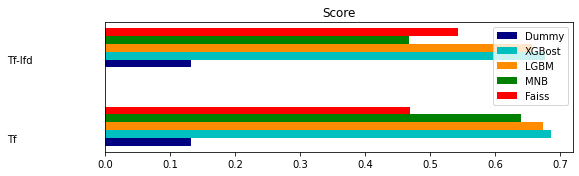

In [0]:
plt.figure(figsize=(10, 2))
plt.title("Score")

plt.barh(indices1, score1[0], .1, label="Dummy", color='navy')
plt.barh(indices1 + .1, score1[1], .1, label="XGBost", color='c')
plt.barh(indices1 + .2, score1[2], .1, label="LGBM", color='darkorange')
plt.barh(indices1 + .3, score1[3], .1, label="MNB", color='green')
plt.barh(indices1 + .4, score1[4], .1, label="Faiss", color='red')

plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices1, feature_model1):
    plt.text(-.15, i, c)

plt.show()

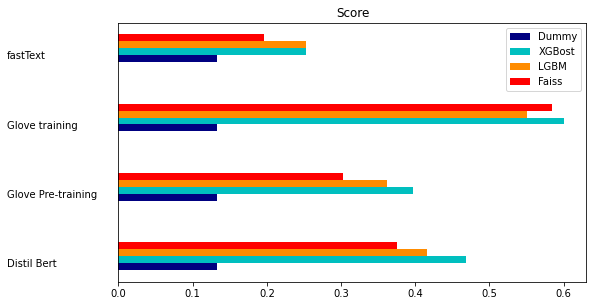

In [0]:
plt.figure(figsize=(10, 4))
plt.title("Score")

plt.barh(indices2, score2[0], .1, label="Dummy", color='navy')
plt.barh(indices2 + .1, score2[1], .1, label="XGBost", color='c')
plt.barh(indices2 + .2, score2[2], .1, label="LGBM", color='darkorange')
#plt.barh(indices2 + .3, score2[3], .1, label="MNB", color='green')
plt.barh(indices2 + .3, score2[3], .1, label="Faiss", color='red')

plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices2, feature_model2):
    plt.text(-.15, i, c)

plt.show()

**Randomized Search**

Vectorizer : Tf

In [0]:
score_bow = {}

In [0]:
X_BOW = X_BOW.astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X_BOW,
                                                    y, test_size = 0.2, random_state = 0)

In [36]:
start_time = time.time()
# XGBoost
grid_xgb.fit(X_train, y_train)

xgb_model_tf = xgb.XGBClassifier(learning_rate=0.1,
                                 objective='reg:logistic',
                                 gamma=grid_xgb.best_params_['gamma'],
                                 max_depth=grid_xgb.best_params_['max_depth'],
                                 min_child_weight=grid_xgb.best_params_['min_child_weight']).fit(X_train, y_train)

#score_bow['XGBoost classifier'] = own_metric(xgb_model_tf, X_test, y_test)

time_svm = time.time() - start_time
print("runtime: %2.fs" % (time_svm))

print("Best params : {}".format(grid_xgb.best_params_))

runtime: 10666s
Best params : {'gamma': 8.407984783100105, 'max_depth': 8, 'min_child_weight': 3}


In [0]:
start_time = time.time()
# LightGBM
grid_lgbm.fit(X_train, y_train)
lgbm_model_tf = LGBMClassifier(learning_rate=0.05,
                               num_leaves=grid_lgbm.best_params_['num_leaves'],
                               max_depth=grid_lgbm.best_params_['max_depth']).fit(X_train, y_train)

score_bow['LGBM classifier'] = own_metric(lgbm_model_tf, X_test, y_test)

time_svm = time.time() - start_time
print("runtime: %2.fs" % (time_svm))

print("Best params : {}".format(grid_lgbm.best_params_))

runtime: 1965s
Best params : {'max_depth': 8, 'num_leaves': 7}


In [0]:
start_time = time.time()
# Naive_bayes MultinomialNB
grid_MNB.fit(X_train, y_train)

MultinomialNB_model_tf = MultinomialNB(alpha=grid_MNB.best_params_['alpha']).fit(X_train, y_train)

score_bow['MultinomialNB classifier'] = own_metric(MultinomialNB_model_tf, X_test, y_test)

time_svm = time.time() - start_time
print("runtime: %2.fs" % (time_svm))

print("Best params : {}".format(grid_MNB.best_params_))

runtime:  9s
Best params : {'alpha': 0.7628006787356286}


In [0]:
score_bow

{'LGBM classifier': 0.7050711743772242,
 'MultinomialNB classifier': 0.6422931494661922,
 'XGBoost classifier': 0.7053491992882562}

Embedding : Glove training

In [0]:
score_glove_training = {}

In [0]:
X_word2vec = X_word2vec.astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X_word2vec,
                                                    y, test_size = 0.2, random_state = 0)

In [0]:
start_time = time.time()
# XGBoost
grid_xgb.fit(X_train, y_train)

xgb_model_gt = xgb.XGBClassifier(learning_rate=0.1,
                                 objective='reg:logistic',
                                 gamma=grid_xgb.best_params_['gamma'],
                                 max_depth=grid_xgb.best_params_['max_depth'],
                                 min_child_weight=grid_xgb.best_params_['min_child_weight']).fit(X_train, y_train)

score_glove_training['XGBoost classifier'] = own_metric(xgb_model_gt, X_test, y_test)

time_svm = time.time() - start_time
print("runtime: %2.fs" % (time_svm))

print("Best params : {}".format(grid_xgb.best_params_))

runtime: 14443s
Best params : {'gamma': 0.30315262678833, 'max_depth': 3, 'min_child_weight': 1}


In [0]:
start_time = time.time()
# LightGBM
grid_lgbm.fit(X_train, y_train)
lgbm_model_gt = LGBMClassifier(learning_rate=0.05,
                               num_leaves=grid_lgbm.best_params_['num_leaves'],
                               max_depth=grid_lgbm.best_params_['max_depth']).fit(X_train, y_train)

score_glove_training['LGBM classifier'] = own_metric(lgbm_model_gt, X_test, y_test)

time_svm = time.time() - start_time
print("runtime: %2.fs" % (time_svm))

print("Best params : {}".format(grid_lgbm.best_params_))

runtime: 873s
Best params : {'max_depth': 9, 'num_leaves': 7}


In [0]:
score_glove_training

{'LGBM classifier': 0.5847419928825622,
 'XGBoost classifier': 0.6000333629893239}

In [0]:
config = {'gamma': xgb_model_tf.gamma, 'max_depth': xgb_model_tf.max_depth,
          'min_child_weight': xgb_model_tf.min_child_weight}
with open('config.json', 'w') as f:
    json.dump(config, f)

**-----------------------**

**Unsupervised Learning**

**-----------------------**

**LDA**

In [0]:
corpus2 = []
for i, row in df_untagged.iterrows():
    obs = str(row["Body"]) + " " + str(row["Title"])
    corpus2.append(obs)

In [0]:
def display_topics(model, no_top_words, num_topics):
    for idx, topic in model.show_topics(formatted=False, num_topics=num_topics, num_words= no_top_words):
        print("--------------------------------------------")
        print("Topic %d:" % (idx))
        print(" ".join([w[0] for w in topic]))
        print("--------------------------------------------")

In [0]:
def display_keywords(model, no_top_words, num_topic, num_topics=30):
  for idx, topic in model.show_topics(formatted=False, num_topics=num_topics, num_words= no_top_words):
    if idx == num_topic:
        return " ".join([w[0] for w in topic])

In [0]:
no_top_words = 10

In [0]:
n_topics = 20

In [0]:
data_lemmatized = [text.split() for text in corpus2]

In [0]:
dictionary = Dictionary(data_lemmatized)

In [0]:
corpus_lda = [dictionary.doc2bow(text) for text in data_lemmatized]

In [0]:
ldaModel = LdaModel(corpus_lda, num_topics=n_topics, id2word=dictionary)

In [0]:
display_topics(ldaModel, no_top_words, n_topics)

--------------------------------------------
Topic 0:
branch test variable change push merge commit work remote want
--------------------------------------------
--------------------------------------------
Topic 1:
file package error version run install server try instal connection
--------------------------------------------
--------------------------------------------
Topic 2:
token code studio visual cookie store app password use hash
--------------------------------------------
--------------------------------------------
Topic 3:
c include code thing struct template end comment int std
--------------------------------------------
--------------------------------------------
Topic 4:
function value option return size directive scope memory way select
--------------------------------------------
--------------------------------------------
Topic 5:
file error message send try server client script create work
--------------------------------------------
-----------------------------

In [0]:
param_n_topics = [20, 25, 30, 35, 40]

In [0]:
perplexity_c_v = []
coherence_c_v = []
model_list = []
for n in param_n_topics:
    model = LdaModel(corpus_lda, num_topics=n, id2word=dictionary)
    model_list.append(model)
    perplexity_c_v.append(model.log_perplexity(corpus_lda))
    coherence_c_v.append(CoherenceModel(model=model,
                                        texts=data_lemmatized,
                                        dictionary=dictionary,
                                        coherence='c_v').get_coherence()
                                        )

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will 

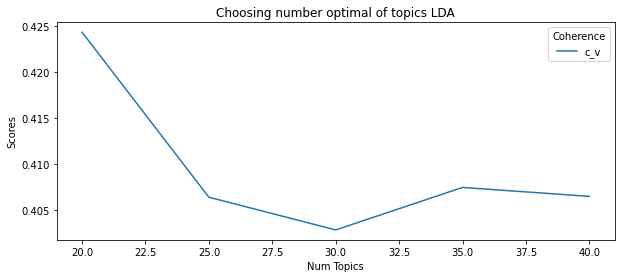

In [0]:
plt.figure(figsize=(10, 4))

plt.plot(param_n_topics, coherence_c_v, label='c_v')

plt.title("Choosing number optimal of topics LDA")
plt.xlabel("Num Topics")
plt.ylabel("Scores")
plt.legend(title='Coherence', loc='best')
plt.show()

In [0]:
ldaModel = model_list[coherence_c_v.index(max(coherence_c_v))]

In [0]:
display_topics(ldaModel, no_top_words, -1)

--------------------------------------------
Topic 0:
error server file try build project run system connection studio
--------------------------------------------
--------------------------------------------
Topic 1:
string double date swift time format contribution type way include
--------------------------------------------
--------------------------------------------
Topic 2:
database key row datum table value store null type data
--------------------------------------------
--------------------------------------------
Topic 3:
test run process thread time nan start output code application
--------------------------------------------
--------------------------------------------
Topic 4:
page content work height web screen size browser application load
--------------------------------------------
--------------------------------------------
Topic 5:
package option version install find com site instal try set
--------------------------------------------
-----------------------------

In [0]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(ldaModel, corpus_lda, dictionary)
LDAvis_prepared

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.110472 -0.118639       1        1  9.702144
15     0.056064  0.145954       2        1  8.984134
10     0.131658 -0.061274       3        1  6.566574
18     0.089401 -0.033046       4        1  6.381387
16    -0.128478  0.125169       5        1  6.360641
4      0.090257 -0.086122       6        1  6.269197
14    -0.061399  0.000453       7        1  5.289968
3      0.086956  0.057125       8        1  4.926160
2      0.010509  0.119201       9        1  4.772036
5      0.127341 -0.055222      10        1  4.603143
7     -0.141636 -0.052426      11        1  4.312747
12    -0.282566 -0.094751      12        1  4.267682
13     0.000131  0.035064      13        1  4.054171
19    -0.017167  0.090936      14        1  3.956619
8     -0.127408 -0.186406      15        1  3.817324
17    -0.025704  0.082996      16        1  3.650821
11     0.058440 -0.102480      17        1  3.132467
1     -0.069466  0.120446      18        1  3.130038
6      0.051713  0.018866      19        1  3.043013
9      0.040882 -0.005843      20        1  2.779735, topic_info=    Category         Freq      Term        Total  loglift  logprob
269  Default  9592.000000      file  9592.000000  30.0000  30.0000
87   Default  4503.000000    string  4503.000000  29.0000  29.0000
139  Default  4891.000000  function  4891.000000  28.0000  28.0000
111  Default  2533.000000     image  2533.000000  27.0000  27.0000
1    Default  5393.000000     class  5393.000000  26.0000  26.0000
..       ...          ...       ...          ...      ...      ...
21   Topic20   141.297150      want  5988.238770  -0.1639  -5.0814
238  Topic20   115.604362      link  1353.407227   1.1226  -5.2820
138  Topic20   121.918648    follow  3054.594971   0.3618  -5.2289
167  Topic20   122.821518       way  5002.181152  -0.1241  -5.2215
92   Topic20   120.757835       add  4342.213379   0.0005  -5.2384

[1496 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1621     14  0.979885          abort
4151      2  0.970640  accelerometer
128       1  0.396834         access
128       2  0.013837         access
128       3  0.035087         access
...     ...       ...            ...
5671      9  0.027049         writer
5671     11  0.750609         writer
5671     12  0.162294         writer
1757      8  0.015597            zip
1757     13  0.967037            zip

[7254 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 16, 11, 19, 17, 5, 15, 4, 3, 6, 8, 13, 14, 20, 9, 18, 12, 2, 7, 10])

**Fonction prédiction tags-keywords**

In [0]:
nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner", "textcat"])

In [0]:
nlp.max_length = 10000000

In [0]:
def lowercase(val):
    return val.lower().strip()

# Change the abbreviations by their full value
def abbreviation(text):
    paires = schwartz_hearst.extract_abbreviation_definition_pairs(doc_text=text)
    keys = [k for k, v in paires.items()]
    document = nlp(text)
    words = []
    for token in document:
        if token.text in keys and  token.text in mean_abbr:
            words.append(paires[token.text])
        else:
            words.append(token.text)

    return ' '.join(words)
    
def remove_contract_form(text):
    document = nltk.word_tokenize(text) #nlp(text)
    words = []
    for token in document:
        text = token
        text = re.sub(r"\'m", "am", text)
        text = re.sub(r"\'re", "are", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"n't", "not", text)
        text = re.sub(r"\'ve", "have", text)
        text = re.sub(r"\'d", "would", text)
        text = re.sub(r"\'ll", "will", text)
        words.append(text)
    return ' '.join(words)

# Delete STOP WORDS
def del_stop_words(text):
    document = nlp(text)
    words = [token.text for token in document if not token.is_stop]
    return ' '.join(words)

# Delete punctuation
def del_punct(text):
    document = nlp(text)
    words = [token.text for token in document if not token.is_punct]
    return ' '.join(words)

# Lemmatization
def lemmatization(text):
    document = nlp(text)
    words = [token.lemma_ for token in document if not token.is_punct]
    return ' '.join(words)

# Remove special characters and bad symbols
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;-_+]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #]')
def clean_spec_bad(text):
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub(' ', text)
    return text

def remove_numbers(text):
    document = nlp(text)
    words = [token.text for token in document if not token.text.isdigit()]
    return ' '.join(words)

def delete_multiple_space(text):
    return ' '.join(text.split())

# Delete string of length = 1 and not in tags
def low_length(text):
    document = nlp(text)
    words = []
    for token in document:
        if len(token.text) > 1:
            words.append(token.text)
        else:
            if token.text in tags:
                words.append(token.text) 
    return ' '.join(words)

def remove_numbers_from_string(text):
    document = nlp(text)
    words = []
    for token in document:
        words.append(''.join([i for i in token.text if not i.isdigit()]))
    return ' '.join(words)

In [0]:
def preprocessing(text):
    text = lowercase(text)
    #text = abbreviation(text)
    text = remove_contract_form(text)
    text = clean_spec_bad(text)
    text = del_stop_words(text)
    text = remove_numbers_from_string(text)
    text = delete_multiple_space(text)
    text = low_length(text)
    text = lemmatization(text)
    return text

In [0]:
clf = xgb_model_tf 

In [0]:
def num_topic(topic_pro):
  max = 0
  nu_top = -1
  for t_p in topic_pro:
      if t_p[1] >= max:
          max = t_p[1]
          nu_top = t_p[0]
  return nu_top

In [0]:
def prediction(body, title):
  c= []
  text = preprocessing(body + " " + title)
  c.append(text)
  X_bt = vectorizer.transform(c)
  input_lda = dictionary.doc2bow(text.split())

  y_preds_pro = clf.predict_proba(X_bt)

  y_preds = y_preds_pro[0].argsort()[-n_labels:][::-1]

  idx_topic = num_topic(ldaModel.get_document_topics(input_lda))

  keywords = display_keywords(ldaModel, no_top_words, idx_topic)

  labels = []
  for i in y_preds:
      labels.append(clf.classes_[i])

  print("The keywords proposed : {}".format(keywords))
  print("The tags proposed : {}".format(labels))
  return (keywords, labels)

In [0]:
n = random.randrange(X_train.shape[0], X_BOW.shape[0])
n

20858

In [0]:
title = corpus_title[n]
body = corpus_body[n]

In [0]:
title

'well way include css use import'

In [0]:
body

'basically wonder advantage purpose import import stylesheets exist stylesheet versus add link rel stylesheet type text css href head document'

In [0]:
k, t = prediction(body, title)

The keywords proposed : text item element style body color class title width css
The tags proposed : ['css', 'html', 'python']


In [0]:
ys[n]  # True tags

['html', 'css']

In [0]:
save_obj(ldaModel, 'lda_model')

In [0]:
save_obj(dictionary, 'dictionary')